# Машинный перевод (English → Russian)

В этом ноутбуке мы обучим модель машинного перевода с английского на русский язык.

## Подходы к машинному переводу

**Статистический перевод (SMT)** — основан на статистических моделях, обученных на параллельных корпусах.

**Нейронный перевод (NMT)** — использует нейронные сети для перевода. Современные системы основаны на архитектуре Transformer.

В этом ноутбуке мы реализуем **нейронный перевод** с помощью модели mT5.

In [1]:
import torch
import pytorch_lightning as pl
import evaluate
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer

## 2. Загрузка и анализ датасета

Используем датасет **OPUS Books** — параллельный корпус из книг. Содержит пары предложений на английском и русском языках.

Каждый пример содержит:
- `en` — предложение на английском
- `ru` — перевод на русский

Для ускорения обучения возьмём подвыборку.

In [2]:
dataset = load_dataset("opus_books", "en-ru")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 17496
    })
})


In [3]:
example = dataset["train"][0]
print("English:", example["translation"]["en"])
print("Russian:", example["translation"]["ru"])

English: Anna Karenina
Russian: Анна Каренина


### Анализ распределения длин предложений

Посмотрим на распределение длин предложений в символах.

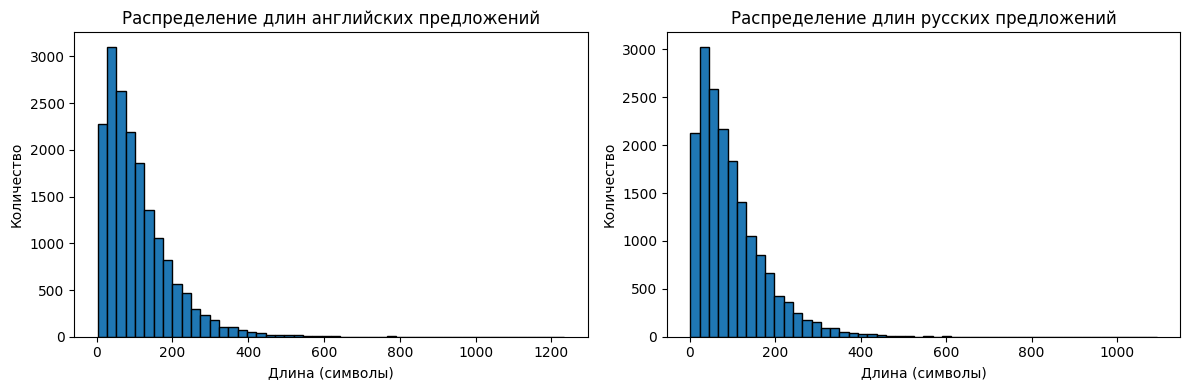

Средняя длина английского: 107 символов
Средняя длина русского: 97 символов


In [4]:
en_lengths = [len(x["translation"]["en"]) for x in dataset["train"]]
ru_lengths = [len(x["translation"]["ru"]) for x in dataset["train"]]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(en_lengths, bins=50, edgecolor="black")
axes[0].set_xlabel("Длина (символы)")
axes[0].set_ylabel("Количество")
axes[0].set_title("Распределение длин английских предложений")

axes[1].hist(ru_lengths, bins=50, edgecolor="black")
axes[1].set_xlabel("Длина (символы)")
axes[1].set_ylabel("Количество")
axes[1].set_title("Распределение длин русских предложений")

plt.tight_layout()
plt.show()

print(f"Средняя длина английского: {sum(en_lengths) / len(en_lengths):.0f} символов")
print(f"Средняя длина русского: {sum(ru_lengths) / len(ru_lengths):.0f} символов")

## 3. Препроцессинг данных

### Модель mT5

Используем **mT5-small** — мультиязычную версию T5, предобученную на 101 языке включая английский и русский.

Для перевода:
- **Вход (encoder)**: предложение на английском с префиксом задачи
- **Выход (decoder)**: перевод на русский

### Токенизация

Ограничим длину входных и выходных текстов до 128 токенов.

In [5]:
MODEL_NAME = "google/mt5-small"
MAX_INPUT_LENGTH = 128
MAX_TARGET_LENGTH = 128

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


### Замена padding токенов на -100

В labels мы заменяем pad токены на `-100`. Это специальное значение, которое функция потерь `CrossEntropyLoss` игнорирует:

$$
\mathcal{L} = -\frac{1}{N_{valid}} \sum_{i: y_i \neq -100} \log p(y_i | x)
$$

### Подготовка данных

Для ускорения обучения возьмём подвыборку из датасета.

In [6]:
TRAIN_SIZE = 10000
VAL_SIZE = 1000

train_dataset = dataset["train"].shuffle(seed=42).select(range(TRAIN_SIZE))
val_dataset = dataset["train"].shuffle(seed=43).select(range(TRAIN_SIZE, TRAIN_SIZE + VAL_SIZE))

print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")

Размер обучающей выборки: 10000
Размер валидационной выборки: 1000


In [7]:
class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, tokenizer, max_input_length, max_target_length, src_lang="en", tgt_lang="ru"):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        input_text = "translate English to Russian: " + item["translation"][self.src_lang]
        target_text = item["translation"][self.tgt_lang]
        
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_input_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        
        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_target_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        
        labels = target_encoding["input_ids"].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            "input_ids": input_encoding["input_ids"].squeeze(),
            "attention_mask": input_encoding["attention_mask"].squeeze(),
            "labels": labels
        }

In [8]:
train_torch_dataset = TranslationDataset(train_dataset, tokenizer, MAX_INPUT_LENGTH, MAX_TARGET_LENGTH)
val_torch_dataset = TranslationDataset(val_dataset, tokenizer, MAX_INPUT_LENGTH, MAX_TARGET_LENGTH)

sample = train_torch_dataset[0]
print("Input shape:", sample["input_ids"].shape)
print("Labels shape:", sample["labels"].shape)

Input shape: torch.Size([128])
Labels shape: torch.Size([128])


## 4. Архитектура модели и обучение

### Encoder-Decoder для перевода

Архитектура seq2seq для перевода:

1. **Encoder** обрабатывает входное предложение и создаёт контекстное представление
2. **Decoder** генерирует перевод токен за токеном, используя cross-attention к encoder

### Функция потерь

Для обучения используется кросс-энтропия:

$$
\mathcal{L} = -\sum_{t=1}^{T} \log p_\theta(y_t | y_{<t}, x)
$$

где:
- $x$ — входное предложение (английский)
- $y = (y_1, \ldots, y_T)$ — целевая последовательность (русский)

### PyTorch Lightning модуль

In [9]:
class TranslationModule(pl.LightningModule):
    def __init__(self, model_name, learning_rate=3e-5, warmup_steps=100):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = T5ForConditionalGeneration.from_pretrained(model_name, use_safetensors=True)
        self.learning_rate = learning_rate
        self.warmup_steps = warmup_steps
    
    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
    
    def training_step(self, batch, batch_idx):
        outputs = self(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        loss = outputs.loss
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        outputs = self(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        loss = outputs.loss
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        
        scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer,
            start_factor=0.1,
            end_factor=1.0,
            total_iters=self.warmup_steps
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            }
        }

## 5. Обучение модели

### Гиперпараметры

- **Batch size**: 16 (с gradient accumulation эквивалентно 64)
- **Learning rate**: 3e-5
- **Epochs**: 3

In [10]:
BATCH_SIZE = 16
ACCUMULATE_GRAD_BATCHES = 4
NUM_EPOCHS = 10
LEARNING_RATE = 3e-5

train_loader = DataLoader(
    train_torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print(f"Количество батчей в train: {len(train_loader)}")
print(f"Количество батчей в val: {len(val_loader)}")

Количество батчей в train: 625
Количество батчей в val: 63


In [11]:
model = TranslationModule(
    model_name=MODEL_NAME,
    learning_rate=LEARNING_RATE,
    warmup_steps=len(train_loader) // ACCUMULATE_GRAD_BATCHES
)

trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator="auto",
    devices=1,
    accumulate_grad_batches=ACCUMULATE_GRAD_BATCHES,
    gradient_clip_val=1.0,
    log_every_n_steps=50,
    enable_progress_bar=True
)

print("Запуск обучения...")
trainer.fit(model, train_loader, val_loader)
print("Обучение завершено!")

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Запуск обучения...



  | Name  | Type                       | Params | Mode
------------------------------------------------------------
0 | model | T5ForConditionalGeneration | 300 M  | eval
------------------------------------------------------------
300 M     Trainable params
0         Non-trainable params
300 M     Total params
1,200.707 Total estimated model params size (MB)
0         Modules in train mode
381       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Обучение завершено!


## 6. Оценка качества

### Метрика BLEU

**BLEU** (Bilingual Evaluation Understudy) — стандартная метрика для оценки качества машинного перевода.

BLEU измеряет совпадение n-грамм между переводом модели и эталонным переводом:

$$
\text{BLEU} = BP \cdot \exp\left(\sum_{n=1}^{N} w_n \log p_n\right)
$$

где:
- $p_n$ — точность n-грамм (precision)
- $w_n = 1/N$ — веса (обычно $N=4$)
- $BP$ — штраф за короткие переводы (brevity penalty):

$$
BP = \begin{cases} 1 & \text{если } c > r \\ e^{1 - r/c} & \text{если } c \leq r \end{cases}
$$

где $c$ — длина перевода, $r$ — длина эталона.

In [12]:
from tqdm.notebook import tqdm

bleu_metric = evaluate.load("sacrebleu")

def generate_translations(model, dataloader, tokenizer, max_length=128, num_beams=1):
    model.eval()
    device = next(model.parameters()).device
    
    predictions = []
    references = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]
            
            generated_ids = model.model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=num_beams,
                early_stopping=True
            )
            
            decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            
            labels_clean = labels.clone()
            labels_clean[labels_clean == -100] = tokenizer.pad_token_id
            decoded_labels = tokenizer.batch_decode(labels_clean, skip_special_tokens=True)
            
            predictions.extend(decoded_preds)
            references.extend([[ref] for ref in decoded_labels])
    
    return predictions, references

In [13]:
print("Генерация переводов на валидационной выборке...")
predictions, references = generate_translations(model, val_loader, tokenizer)

results = bleu_metric.compute(predictions=predictions, references=references)

print(f"\nРезультаты:")
print(f"BLEU: {results['score']:.2f}")

Генерация переводов на валидационной выборке...


  0%|          | 0/63 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Результаты:
BLEU: 13.05


## 7. Инференс и демонстрация

Протестируем модель на нескольких примерах.

In [14]:
def translate_text(model, tokenizer, text, max_input_length=128, max_output_length=128, num_beams=4):
    model.eval()
    device = next(model.parameters()).device
    
    input_text = "translate English to Russian: " + text
    inputs = tokenizer(
        input_text,
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    
    with torch.no_grad():
        generated_ids = model.model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_output_length,
            num_beams=num_beams,
            early_stopping=True
        )
    
    translation = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return translation

In [15]:
print("Примеры перевода:\n")
print("=" * 80)

for i in range(5):
    example = val_dataset[i]
    source_text = example["translation"]["en"]
    reference_translation = example["translation"]["ru"]
    
    generated_translation = translate_text(model, tokenizer, source_text)
    
    print(f"\nПример {i + 1}")
    print("-" * 40)
    print(f"English: {source_text}")
    print(f"\nЭталонный перевод:\n{reference_translation}")
    print(f"\nПеревод модели:\n{generated_translation}")
    print("=" * 80)

Примеры перевода:


Пример 1
----------------------------------------
English: 'He hates me, that is clear,' thought she, and silently, without looking round and with faltering steps, she left the room.

Эталонный перевод:
"Он ненавидит меня, это ясно", -- подумала она и молча, не оглядываясь, неверными шагами вышла из комнаты.

Перевод модели:
-- Он ненавидит меня, это ясно, -- сказала она и, не глядя и не шагая за шагами, она вышла из комнаты.

Пример 2
----------------------------------------
English: 'In Society it is hell!' he said quickly with a dark frown. 'It is impossible to imagine greater moral torments than those she endured for two weeks in Petersburg... I beg you to believe me!'

Эталонный перевод:
-- В свете это ад!-- мрачно нахмурившись, быстро проговорил он. -- Нельзя представить себе моральных мучений хуже тех, которые она пережила в Петербурге в две недели... и я прошу вас верить этому.

Перевод модели:
-- В обществе правда, правда, правда, правда, нельзя было себе п